In [1]:
import os
from tqdm import tqdm

DATA_FOLDER = 'english_1M_normalized_chunks'

class Token:
    def __init__(self, line):
        line = line.split()
        self.form = line[1]
        self.pos = line[3]
        
    def __repr__(self):
        return '({}, {})'.format(self.form, self.pos)

# folder must contain .predict files output by TweeboParser
# for each tweet, the first token is the tweet id
# return a dictionary, where each entry represents a tweet
# keys are tweet ids and values are lists of Tokens 
def read_tweets(folder):
    tweet_dict = {}
    for fn in tqdm(os.listdir(folder)):
        if fn.endswith('.txt.predict'):
            with open(os.path.join(folder, fn), encoding='utf-8') as infile:
                content = infile.read()
                for tweet in content.split('\n\n'): 
                    tweet = tweet.split('\n')
                    if not len(tweet) > 2:  # ensure tweet contains at least one word
                        continue

                    tweet_id = tweet[0].split('\t')[1][1:]
                    text = [Token(line) for line in tweet[1:]]
                    tweet_dict[tweet_id] = text
                    
    return tweet_dict 
            
tweet_dict = read_tweets(DATA_FOLDER)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:04<00:00,  6.91it/s]


In [2]:
from itertools import chain
from collections import Counter
import json

def filter_case(counter):
    # count title case as lower case, and only 
    # distinguish between upper vs lower case
    counter = dict(counter)
    for form in list(counter.keys()):
        if form.istitle():
            word = form.lower()
            if word in counter:
                counter[word] += counter[form]
            else:
                counter[word] = counter[form]
            del counter[form]
        elif not (form.isupper() or form.islower()):
            del counter[form]
        
    return counter


def count_tokens(tweet_dict):
    text = chain.from_iterable(tweet_dict.values())
    counter = Counter()
    text = filter(lambda tok: tok.pos not in {'#', '@', 'U', 'E'} and tok.form.isalpha(), text)
    forms = [tok.form for tok in text]
    counter = Counter(forms)
    
    return filter_case(counter)

In [3]:
import re 
from collections import defaultdict

lengthened_word_re = re.compile(r"""
    ^                   # string start
    [A-Za-z-]*          # 0 or more characters
    ([A-Za-z-])\1{1,}   # 2 or more of the same character
    [A-Za-z-]*          # 0 or more characters
    $                   # string end
    """, re.VERBOSE)

two_char_re = re.compile(r'([A-Za-z-])\1{1,}')  # sequence of 2 or more repeated
three_char_re = re.compile(r'([A-Za-z-])\1{2,}')

# need to create lengthening map from english_1M data
# e.g. heroicaly -> heroically 
def get_normal_map(counter):
    counts = defaultdict(Counter)
    for word, n in tqdm(counter.items()):
        if not word.isalpha():
            continue
            
        word = word.lower()
        if lengthened_word_re.match(word):
            short = two_char_re.sub(r'\1', word)
            counts[short][word] = n

    mapping = {}
    for short, n in counts.items():
        forms = n.most_common()
        canon = forms[0][0]
        if short != canon and not three_char_re.search(canon):
            mapping[short] = canon
                    
    return mapping

In [4]:
def count_caps(tok_counter):
    normal_map = get_normal_map(tok_counter)
    counts = defaultdict(lambda: defaultdict(int))
    
    for word, count in tok_counter.items():
        form = word.lower()
        
        if lengthened_word_re.match(form):
            form = two_char_re.sub(r'\1', form)
            if form in normal_map:
                form = normal_map[form]
                
        if len(form) > 2:
            entry = counts[form]
            if word.isupper():
                entry['upper'] += 1
            else:
                entry['non-upper'] += 1

    return counts

In [5]:
dict_path = os.path.join('creating lexicons', 'data', '15M_sample', '_15M_sample_words.txt')
big_counter = {}
with open(dict_path, encoding='utf-8') as infile:
    for line in tqdm(infile):
        line = line.split('\t')
        word = line[0]
        if word.isalpha():
            big_counter[word] = int(line[1])

counter = count_tokens(tweet_dict)
all_counter = Counter(counter) + Counter(big_counter)
all_counts = count_caps(all_counter)

2537320it [00:08, 285942.33it/s]
100%|████████████████████████████████████████████████████████████████████| 1144596/1144596 [00:11<00:00, 100815.43it/s]


In [6]:
all_counts

defaultdict(<function __main__.count_caps.<locals>.<lambda>>,
            {'lok': defaultdict(int, {'non-upper': 62, 'upper': 25}),
             'forward': defaultdict(int, {'non-upper': 3, 'upper': 1}),
             'reading': defaultdict(int, {'non-upper': 5, 'upper': 1}),
             'lively': defaultdict(int, {'non-upper': 2, 'upper': 1}),
             'tweets': defaultdict(int, {'non-upper': 15, 'upper': 4}),
             'the': defaultdict(int, {'non-upper': 7, 'upper': 1}),
             'future': defaultdict(int, {'non-upper': 19, 'upper': 8}),
             'nascent': defaultdict(int, {'non-upper': 2}),
             'microinsurance': defaultdict(int, {'non-upper': 1}),
             'market': defaultdict(int, {'non-upper': 3, 'upper': 1}),
             'pushed': defaultdict(int, {'non-upper': 2, 'upper': 1}),
             'myself': defaultdict(int, {'non-upper': 44, 'upper': 8}),
             'liitle': defaultdict(int, {'non-upper': 58, 'upper': 8}),
             'harder': defau

In [7]:
# compute ratio of upper/non-upper for all words

def get_ratios(counts):
    ratio_dict = {}

    for tok, c in counts.items():
        if 'upper' in c and 'non-upper' in c:
            ratio_dict[tok] = c['upper'] / (c['non-upper'] + c['upper'])
    
    return ratio_dict

In [8]:
len(all_counts)

733729

In [9]:
ratio_dict = get_ratios(all_counts)
ratio_dict

{'lok': 0.28735632183908044,
 'forward': 0.25,
 'reading': 0.16666666666666666,
 'lively': 0.3333333333333333,
 'tweets': 0.21052631578947367,
 'the': 0.125,
 'future': 0.2962962962962963,
 'market': 0.25,
 'pushed': 0.3333333333333333,
 'myself': 0.15384615384615385,
 'liitle': 0.12121212121212122,
 'harder': 0.2,
 'today': 0.2980769230769231,
 'run': 0.4444444444444444,
 'fels': 0.20588235294117646,
 'great': 0.17063492063492064,
 'twatch': 0.3333333333333333,
 'you': 0.3055555555555556,
 'horrible': 0.15384615384615385,
 'how': 0.2967032967032967,
 'did': 0.2,
 'that': 0.2087912087912088,
 'hapen': 0.13636363636363635,
 'only': 0.14634146341463414,
 'works': 0.15384615384615385,
 'have': 0.18461538461538463,
 'settle': 0.16666666666666666,
 'with': 0.17073170731707318,
 'apps': 0.2857142857142857,
 'for': 0.2777777777777778,
 'meantime': 0.25,
 'buy': 0.3125,
 'voip': 0.25,
 'anywhere': 0.16666666666666666,
 'nice': 0.22875816993464052,
 'tel': 0.2564102564102564,
 'right': 0.132258

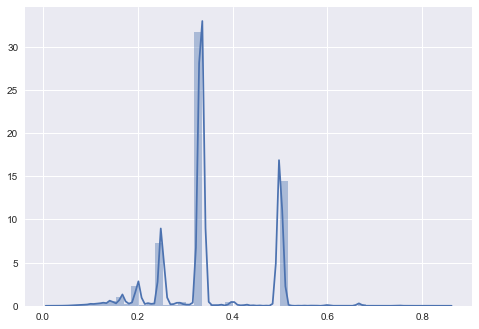

In [10]:
import seaborn as sb

ratio_dict = get_ratios(all_counts)
sb.distplot(list(ratio_dict.values()))
sb.plt.show()

In [11]:
import numpy as np

values = np.array(list(ratio_dict.values()))
p = np.percentile(values, 80)
p

0.5

In [12]:
[k for k, v in ratio_dict.items() if v > 0.51]

['films',
 'hyped',
 'scores',
 'vip',
 'detroit',
 'goal',
 'zoom',
 'norm',
 'pta',
 'jungle',
 'mao',
 'bmm',
 'medicine',
 'greedy',
 'crawling',
 'sdcc',
 'niece',
 'mjj',
 'bachelor',
 'mrt',
 'moaning',
 'kevin',
 'james',
 'screamed',
 'spammer',
 'waits',
 'smallest',
 'bruce',
 'wok',
 'beyonce',
 'ovi',
 'panthers',
 'immune',
 'duval',
 'disco',
 'bttf',
 'thong',
 'fock',
 'ccaa',
 'africa',
 'ultra',
 'subscribe',
 'pbc',
 'raiders',
 'gordon',
 'underground',
 'warriors',
 'pinot',
 'ootb',
 'iic',
 'ree',
 'papp',
 'tampa',
 'buck',
 'llm',
 'filme',
 'tidak',
 'sharks',
 'klcc',
 'rcc',
 'volumes',
 'brandon',
 'frikken',
 'sparta',
 'anthonyy',
 'fallout',
 'germs',
 'zomfg',
 'eeoc',
 'alk',
 'aarp',
 'hewwo',
 'spurs',
 'dvi',
 'pointer',
 'sweah',
 'lowry',
 'ovechkin',
 'rbc',
 'rumblepurr',
 'brooks',
 'sff',
 'bwhahahahha',
 'bbh',
 'jenkins',
 'impeach',
 'harden',
 'ddb',
 'gdd',
 'squees',
 'wahahah',
 'undercover',
 'theo',
 'ttv',
 'xvi',
 'cbbc',
 'ppd',
 

In [51]:
# map tweet ids to sentiment and gender
# count the number of meaningfully capitalized words in each tweet

def is_meaningful(word):
    word = word.lower()
#     if word in ratio_dict and ratio_dict[word] < 0.51:
#         return True
#     return False
    entry = all_counts[word]
    if entry['upper'] > entry['non-upper']:
        return False
    return True

caps_count = {}

normal_map = get_normal_map(counter)

for tweet_id, tok_list in tqdm(tweet_dict.items()):
    p_meaningful = 0
    n_meaningful = 0
    n_caps = 0
    pos_list = []
    # throw out tweets that are all capitalized 
    tok_list = list(filter(lambda x: x.pos not in {'#', '@', 'U', 'E', ','} and len(x.form) > 2, tok_list))
    
    if not tok_list:
        caps_count[int(tweet_id)] = 0
        continue
    
    for tok in tok_list:
        word = tok.form
        pos_list.append(tok.pos)
        
        if word.isupper():
            n_caps += 1
            if lengthened_word_re.match(word):
                normal = two_char_re.sub(r'\1', word)
                if normal.lower() in normal_map:
                    normal = normal_map[normal.lower()].upper()
                    
                word = normal
            
            if is_meaningful(word):
                n_meaningful += 1
    
    p_meaningful = n_meaningful / len(tok_list)
    if n_caps / len(tok_list) > 0.8:
        # most of the words are capitalized, so that's not useful
        # capitalizing the whole sequence is a different phenomenon,
        # not what I'm trying to look at 
        p_meaningful = 0
        
    caps_count[int(tweet_id)] = p_meaningful * 100

100%|███████████████████████████████████████████████████████████████████████| 854978/854978 [00:44<00:00, 19312.05it/s]


In [52]:
import pandas as pd

SENTIMENT_GENDER_DATA = 'english_1M_sentiment_gender.csv'
df = pd.read_csv(SENTIMENT_GENDER_DATA, encoding='utf-8', index_col=0)
df.head()

,tweet,sentiment,gender
tweet_id,,,
1790240517,"@TeresaMedeiros Seven pieces? My, Terri, you'...",positive,Female
2659644516,"Anytime, Anywhere by S Club 7 http /bit.ly/ylXR0",positive,Male
4346763911,the anti-obama song: http /bit.ly/r65dG,positive,Male
5020452215,"@princesskitten I'm RSVPing with a no, and don...",positive,Female
5014008695,@miccee yes and no it was his DAD Martin altho...,positive,Female


In [53]:
df['caps_percentage'] = pd.Series(caps_count)

df.head()

,tweet,sentiment,gender,caps_percentage
tweet_id,,,,
1790240517,"@TeresaMedeiros Seven pieces? My, Terri, you'...",positive,Female,0.000000
2659644516,"Anytime, Anywhere by S Club 7 http /bit.ly/ylXR0",positive,Male,0.000000
4346763911,the anti-obama song: http /bit.ly/r65dG,positive,Male,0.000000
5020452215,"@princesskitten I'm RSVPing with a no, and don...",positive,Female,0.000000
5014008695,@miccee yes and no it was his DAD Martin altho...,positive,Female,9.090909


In [54]:
df = df.dropna(axis=0)

In [55]:
df.to_csv('english_1M_sentiment_gender_caps_percentage.csv', encoding='utf-8')

In [21]:
df.shape

(36003, 4)

(4831, 4)


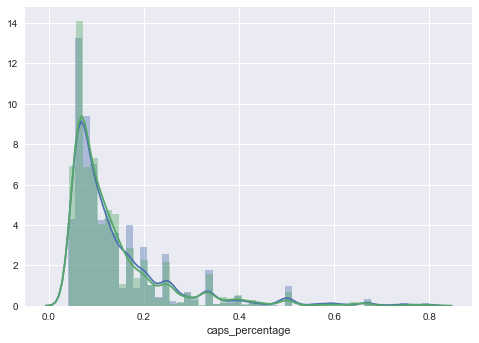

In [50]:
def select_data(df, sentiment, gender):
    return df.loc[(df['sentiment'] == sentiment) & (df['gender'] == gender)]['caps_percentage']

df = df.loc[df['caps_percentage'] > 0]
print(df.shape)

pos_female = select_data(df, 'positive', 'Female')
neg_female = select_data(df, 'negative', 'Female')
pos_male = select_data(df, 'positive', 'Male')
neg_male = select_data(df, 'negative', 'Male')

# plot female vs male
female = df.loc[df['gender'] == 'Female']['caps_percentage']
male = df.loc[df['gender'] == 'Male']['caps_percentage']

sb.distplot(female)
sb.distplot(male)
sb.plt.show()

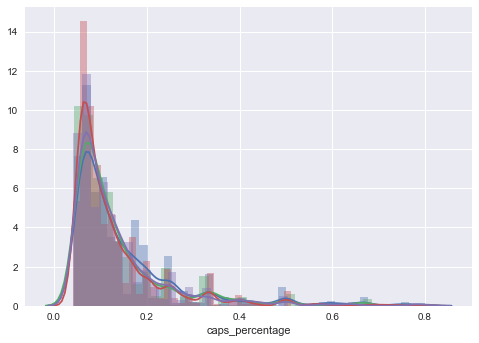

In [48]:
# plot positive male vs positive female
sb.distplot(pos_female)
sb.distplot(pos_male)
sb.distplot(neg_female)
sb.distplot(neg_male)
sb.plt.show()

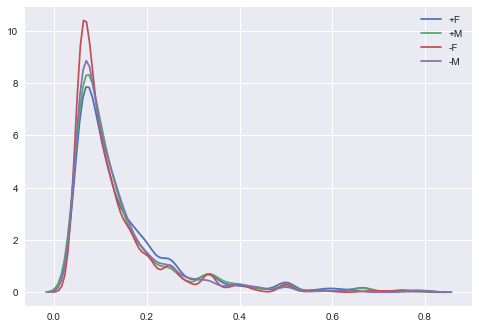

In [49]:
sb.kdeplot(pos_female, label='+F')
sb.kdeplot(pos_male, label='+M')
sb.kdeplot(neg_female, label='-F')
sb.kdeplot(neg_male, label='-M')
sb.plt.show()